In [3]:
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import yaml

import sys
sys.path.append('../')
sys.path.append('../../')

from TMaze_new.TMaze_new_src.utils.tmaze import TMazeClassicPassive
from TMaze_new.TMaze_new_src.utils import seeds_list
from TMaze_new.TMaze_new_src.inference.val_tmaze import get_returns_TMaze
from RATE_delete_after import mem_transformer_v2_GTrXL

import torch
import torch.nn as nn

In [4]:
with open("../../TMaze_new/TMaze_new_src/config.yaml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

config["model_mode"] = 'RATE'
config["arctitecture_mode"] = 'TrXL'

mem_len = 0
nmt = 5
n_head_ca = 4
mrv_act = 'relu'
skip_dec_ffn = False

config['model_config']['skip_dec_ffn'] = skip_dec_ffn

""" ARCHITECTURE MODE """
if config["arctitecture_mode"] == "TrXL":
    config["model_config"]["use_gate"] = False
    config["model_config"]["use_stable_version"] = False
elif config["arctitecture_mode"] == "TrXL-I":
    config["model_config"]["use_gate"] = False
    config["model_config"]["use_stable_version"] = True
elif config["arctitecture_mode"] == "GTrXL":
    config["model_config"]["use_gate"] = True
    config["model_config"]["use_stable_version"] = True     

print(f"Selected Architecture: {config['arctitecture_mode']}")  

""" MODEL MODE """
if config["model_mode"] == "RATE": 
    config["model_config"]["mem_len"] = mem_len
    config["model_config"]["mem_at_end"] = True
    config["model_config"]["num_mem_tokens"] = nmt
    config["model_config"]["n_head_ca"] = n_head_ca
    config["model_config"]["mrv_act"] = mrv_act

elif config["model_mode"] == "DT":
    config["model_config"]["mem_len"] = 0
    config["model_config"]["mem_at_end"] = False
    config["model_config"]["num_mem_tokens"] = 0
    config["model_config"]["n_head_ca"] = 0
    config["training_config"]["context_length"] = config["training_config"]["context_length"] * config["training_config"]["sections"]
    config["training_config"]["sections"] = 1
    max_length = config["training_config"]["context_length"]

elif config["model_mode"] == "DTXL":
    config["model_config"]["mem_len"] = mem_len
    config["model_config"]["mem_at_end"] = False
    config["model_config"]["num_mem_tokens"] = 0
    config["model_config"]["n_head_ca"] = 0
    config["training_config"]["context_length"] = config["training_config"]["context_length"] * config["training_config"]["sections"]
    config["training_config"]["sections"] = 1
    max_length = config["training_config"]["context_length"]

elif config["model_mode"] == "RATEM":
    config["model_config"]["mem_len"] = 0
    config["model_config"]["mem_at_end"] = True
    config["model_config"]["num_mem_tokens"] = nmt
    config["model_config"]["n_head_ca"] = n_head_ca
    config["model_config"]["mrv_act"] = mrv_act
    max_length = config["training_config"]["sections"]*config["training_config"]["context_length"]

elif config["model_mode"] == "RATE_wo_nmt":
    print("Custom Mode!!! RATE wo nmt")
    config["model_config"]["mem_len"] = mem_len
    config["model_config"]["mem_at_end"] = False
    config["model_config"]["num_mem_tokens"] = 0
    config["model_config"]["n_head_ca"] = 0
    max_length = config["training_config"]["sections"]*config["training_config"]["context_length"]

if nmt == 0:
    config["model_config"]["mem_at_end"] = False

model = mem_transformer_v2_GTrXL.MemTransformerLM(**config["model_config"])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Selected Architecture: TrXL
cuda


In [ ]:
ckpt_folder = '../../TMaze_new/rate_3_tmaze_no_curr/RATE_3_nmt_5_nhca_4_arch_mode_TrXL_RATE_min_1_max_3_RUN_1_2024_09_04_23_41_55'
name = '_save_KTD.pth'

ckpt_path = f'../../TMaze_new/TMaze_new_checkpoints/{ckpt_folder}/'

folder_path = ckpt_path

model.load_state_dict(torch.load(ckpt_path + name, map_location=device), strict=True)
model.to(device)
print(f"model parameters: {sum(p.numel() for p in list(model.parameters()))}")
_ = model.eval()  

In [6]:
@torch.no_grad()
def sample(model, x, block_size, steps, sample=False, top_k=None, actions=None, rtgs=None, timestep=None, mem_tokens=1, saved_context=None):
    
    model.eval()
    for k in range(steps):
        x_cond = x if x.size(1) <= block_size else x[:, -block_size:] # crop context if needed
        if actions is not None:
            actions = actions if actions.size(1) <= block_size else actions[:, -block_size:] # crop context if needed
        rtgs = rtgs if rtgs.size(1) <= block_size else rtgs[:, -block_size:] # crop context if needed
        
        if saved_context is not None:
            results = model(x_cond, actions, rtgs, None, timestep, *saved_context, mem_tokens=mem_tokens)
        else:
            results = model(x_cond, actions, rtgs, None, timestep, mem_tokens=mem_tokens) 

        logits = results[0][0][:,-1,:]
        mem_tokens = results[1]
        memory = results[0][2:]
        attn_map = model.attn_map
        
    return logits, mem_tokens, memory, attn_map

def get_returns_TMaze(model, ret, seed, episode_timeout, corridor_length, context_length, device, act_dim, config, create_video=False):
    
    scale = 1
    channels = 5
    max_ep_len = episode_timeout

    env = TMazeClassicPassive(episode_length=episode_timeout, corridor_length=corridor_length, penalty=0, seed=seed, goal_reward=ret)
    state = env.reset() # {x, y, hint}
    np.random.seed(seed)
    where_i = state[0]
    mem_state = state[2]
    mem_state2 = state

    state = np.concatenate((state, np.array([0]))) # {x, y, hint, flag}
    state = np.concatenate((state, np.array([np.random.randint(low=-1, high=1+1)]))) # {x, y, hint, flag, noise}

    if create_video == True:
        print("down, required act: 3" if mem_state == -1.0 else "up,  required act: 1")

    state = torch.tensor(state).reshape(1, 1, channels)
    out_states = []
    out_states.append(state.cpu().numpy())
    done = True
    Flag = 0
    HISTORY_LEN = context_length
    
    rews = []
    states = state.to(device=device, dtype=torch.float32)
    actions = torch.zeros((0, act_dim), device=device, dtype=torch.float32)
    rewards = torch.zeros(0, device=device, dtype=torch.float32)
    target_return = torch.tensor(ret, device=device, dtype=torch.float32).reshape(1, 1)
    episode_return, episode_length = 0, 0

    mem_tokens = model.mem_tokens.repeat(1, 1, 1).detach() if model.mem_tokens is not None else None
    memories = [mem_tokens.detach().cpu()]
    model.cache = mem_tokens.clone() if mem_tokens is not None else None
    
    saved_context = None
    segment = 0
    prompt_steps = 0
    act = None
    act_list= []

    switcher = False
    attn_maps = []
    attn_maps_seg = []
    

    for t in range(max_ep_len):
        actions = torch.cat([actions, torch.zeros((1, act_dim), device=device)], dim=0)
        rewards = torch.cat([rewards, torch.zeros(1, device=device)])
        
        if config["model_mode"] != 'DT' and config["model_mode"] != 'DTXL':
            if actions.shape[0] > HISTORY_LEN:
                segment+=1
                
                if prompt_steps==0:
                    actions = actions[-1:,:]
                    states = states[:, -1:, :]
                    target_return = target_return[:,-1:]
                    
                if t%(context_length)==0:
                    if create_video:
                        out = torch.norm(mem_tokens).item() if mem_tokens is not None else None
                        print(f't: {t}, NEW MEMORY: {out}')
                        
                    mem_tokens = new_mem
                    memories.append(mem_tokens.detach().cpu())
                    saved_context = new_notes
                
        else:
            if actions.shape[0] > HISTORY_LEN:
                segment+=1
                
                if prompt_steps==0:
                    actions = actions[1:,:]
                    states = states[:, 1:, :]
                    target_return = target_return[:,1:]
                    
                if t%(context_length)==0:
                    if create_video:
                        out = torch.norm(mem_tokens).item() if mem_tokens is not None else None
                        print(f't: {t}, NEW MEMORY: {out}')
                    mem_tokens = new_mem
                    saved_context = new_notes
                
        if t==0:
            act_to_pass = None
        else:
            act_to_pass = actions.unsqueeze(0)[:, 1:, :]
            if act_to_pass.shape[1] == 0:
                act_to_pass = None 
        
        sampled_action, new_mem, new_notes, attn_map = sample(model=model,  
                                                        x=states[:, :, 1:],
                                                        block_size=HISTORY_LEN, 
                                                        steps=1, 
                                                        sample=True, 
                                                        actions=act_to_pass, 
                                                        rtgs=target_return.unsqueeze(-1), 
                                                        mem_tokens=mem_tokens,
                                                        saved_context=saved_context)
        
        if t > 0 and t % (context_length-1) == 0 and switcher == False:
            switcher = True

        act = torch.argmax(torch.softmax(sampled_action, dim=-1).squeeze()).item()
        if create_video:
            print(t, "act", act, np.round(torch.softmax(sampled_action, dim=-1).squeeze().detach().cpu().numpy(), 3), "\tstate:", int(where_i), states[:, -1:, :].detach().cpu().numpy())
        actions[-1, :] = act
        act_list.append(act)
        state, reward, done, info = env.step(act)
        
        if t < config["data_config"]["hint_steps"]-1:
            state[2] = mem_state2[2]
        
         # {x, y, hint} -> {x, y, hint, flag}
        if state[0] != env.corridor_length:
            state = np.concatenate((state, np.array([0])))
        else:
            if Flag != 1:
                state = np.concatenate((state, np.array([1])))
                Flag = 1
            else:
                state = np.concatenate((state, np.array([0])))
                
        # {x, y, hint, flag} -> {x, y, hint, flag, noise}
        state = np.concatenate((state, np.array([np.random.randint(low=-1, high=1+1)])))
        
        
        delta_t = env.time_step - env.corridor_length - 1
        where_i = state[0]
        state = state.reshape(1, 1, channels)
        out_states.append(state)
        
        rews.append(reward)
        cur_state = torch.from_numpy(state).to(device=device).float()
        states = torch.cat([states, cur_state], dim=1)
        rewards[-1] = reward
        pred_return = target_return[0,-1] - (reward/scale)
        target_return = torch.cat([target_return, pred_return.reshape(1, 1)], dim=1)
        episode_return += reward
        episode_length += 1
        
        attn_maps.append(attn_map)
        
        if (t+1) % (context_length) == 0 and t > 0:
            attn_maps_seg.append(attn_map)
            
        if done:
            if create_video == True:
                if np.round(where_i, 4) == np.round(corridor_length, 4):
                    print("Junction achieved 😀 ✅✅✅")
                    print("Chosen act:", "up" if act == 1 else "down" if act == 3 else "wrong")
                    if mem_state == -1 and act == 3:
                        print("Correct choice 😀 ✅✅✅")
                    elif mem_state == 1 and act == 1:
                        print("Correct choice 😀 ✅✅✅")
                    else:
                        print("Wrong choice 😭 ⛔️⛔️⛔️")
                else:
                    print("Junction is not achieved 😭 ⛔️⛔️⛔️")
                
                print(f"{np.round(torch.softmax(sampled_action, dim=-1).squeeze().detach().cpu().numpy(),2)}")
            break  
    if create_video == True:
        print(f"Final position: [{int(where_i)}, {int(np.round(states.squeeze()[-1].tolist()[0 if channels == 3 else 1]))}] / [{int(corridor_length)}, {int(mem_state)}]")
        print("\n")
        
    return reward, act_list, t, np.array(out_states).squeeze(), delta_t, attn_maps, attn_maps_seg, memories

In [7]:
segments = 3
episode_timeout = 30*segments
corridor_length = 30*segments - 2
create_video = True
seed = 1

episode_return, act_list, t, states, _, attn_maps, attn_maps_seg, memories = get_returns_TMaze(model=model, ret=config["data_config"]["desired_reward"], seed=seed, 
                                                                    episode_timeout=episode_timeout, corridor_length=corridor_length, 
                                                                    context_length=config["training_config"]["context_length"], 
                                                                    device=device, act_dim=config["model_config"]["ACTION_DIM"], 
                                                                    config=config, create_video=create_video)

print(episode_return)

up,  required act: 1
0 act 0 [1. 0. 0. 0.] 	state: 0 [[[0. 0. 1. 0. 0.]]]
1 act 0 [1. 0. 0. 0.] 	state: 1 [[[ 1.  0.  0.  0. -1.]]]
2 act 0 [1. 0. 0. 0.] 	state: 2 [[[ 2.  0.  0.  0. -1.]]]
3 act 0 [1. 0. 0. 0.] 	state: 3 [[[3. 0. 0. 0. 0.]]]
4 act 0 [1. 0. 0. 0.] 	state: 4 [[[4. 0. 0. 0. 0.]]]
5 act 0 [1. 0. 0. 0.] 	state: 5 [[[ 5.  0.  0.  0. -1.]]]
6 act 0 [1. 0. 0. 0.] 	state: 6 [[[ 6.  0.  0.  0. -1.]]]
7 act 0 [1. 0. 0. 0.] 	state: 7 [[[7. 0. 0. 0. 0.]]]
8 act 0 [1. 0. 0. 0.] 	state: 8 [[[ 8.  0.  0.  0. -1.]]]
9 act 0 [1. 0. 0. 0.] 	state: 9 [[[9. 0. 0. 0. 0.]]]
10 act 0 [1. 0. 0. 0.] 	state: 10 [[[10.  0.  0.  0. -1.]]]
11 act 0 [1. 0. 0. 0.] 	state: 11 [[[11.  0.  0.  0.  1.]]]
12 act 0 [1. 0. 0. 0.] 	state: 12 [[[12.  0.  0.  0.  0.]]]
13 act 0 [1. 0. 0. 0.] 	state: 13 [[[13.  0.  0.  0.  1.]]]
14 act 0 [1. 0. 0. 0.] 	state: 14 [[[14.  0.  0.  0. -1.]]]
15 act 0 [1. 0. 0. 0.] 	state: 15 [[[15.  0.  0.  0.  1.]]]
16 act 0 [1. 0. 0. 0.] 	state: 16 [[[16.  0.  0.  0.  0.]]]
17 a

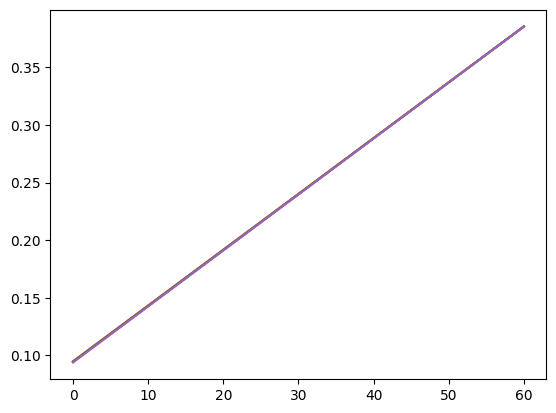

In [8]:
cos = nn.CosineSimilarity(dim=-1, eps=1e-6)

mem_tokens_to_print = {nmt: [] for nmt in range(memories[0].shape[0])}

for i in range(1, len(memories)):
    for nmt in range(memories[0].shape[0]):
        cos_sim = cos(memories[i][nmt], memories[i-1][nmt]).item()
        mem_tokens_to_print[nmt].append(cos_sim)

fig, ax = plt.subplots(1, 1)

for nmt in range(memories[0].shape[0]):
    ax.plot(2*np.arange(0, (len(memories)-1)*30, 30), mem_tokens_to_print[nmt])

plt.show()

In [9]:
n_heads = attn_maps[0].shape[-1]
print(f"n_heads: {n_heads}")

n_heads: 10


0
(99, 99)


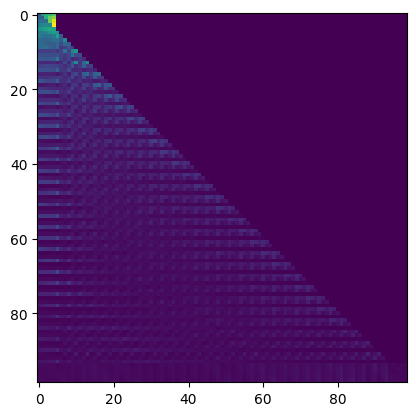

1
(99, 99)


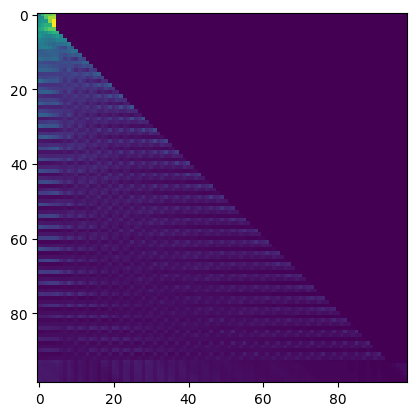

In [10]:
for i in range((len(attn_maps) // 30)):
    print(i)
    map_ = attn_maps[29+30*i][:, :, 0, 8]
    map_ = torch.softmax(map_, dim=1).numpy()
    print(map_.shape)
    plt.imshow(map_)
    plt.show()

99
2


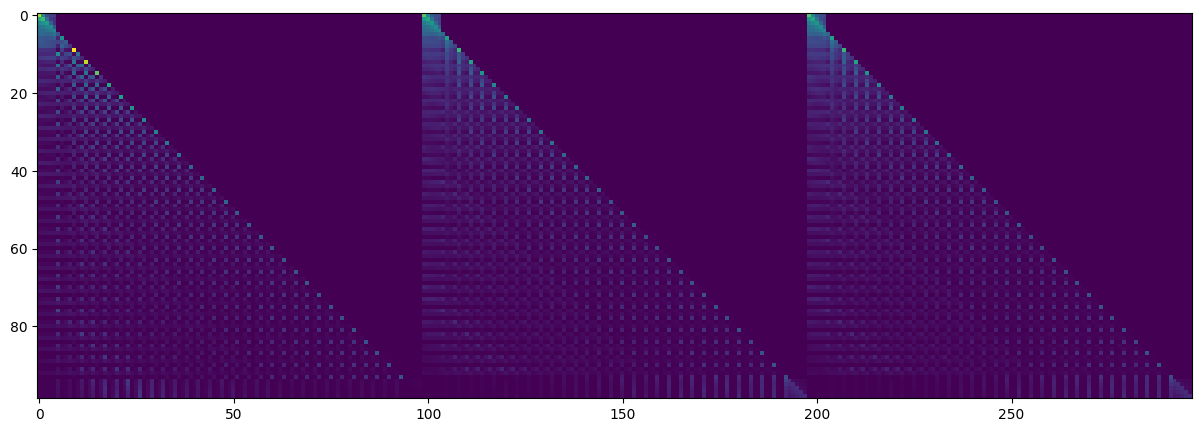

99
2


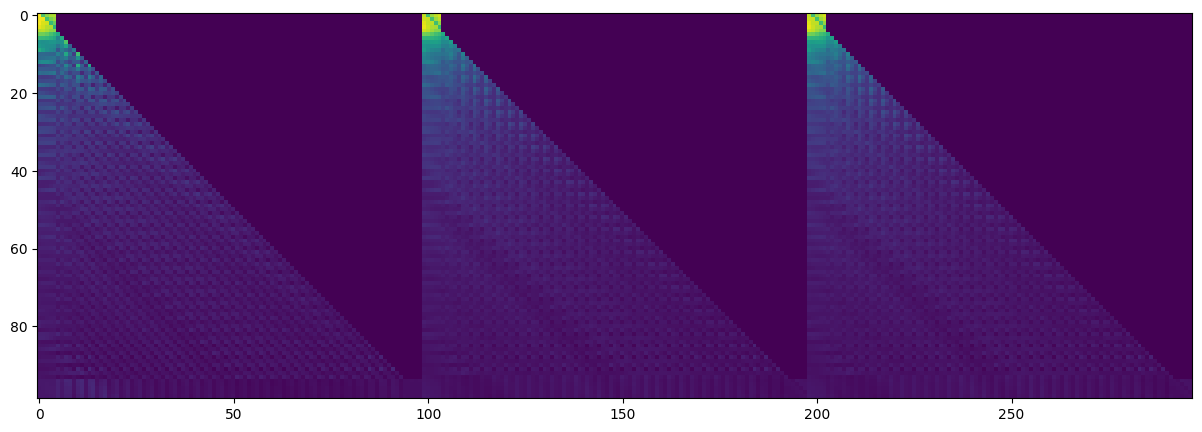

99
2


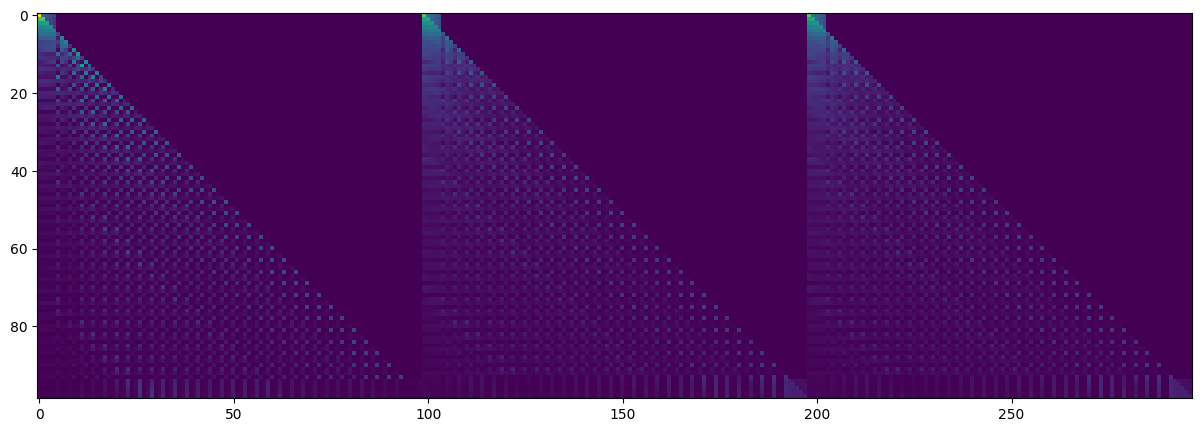

99
2


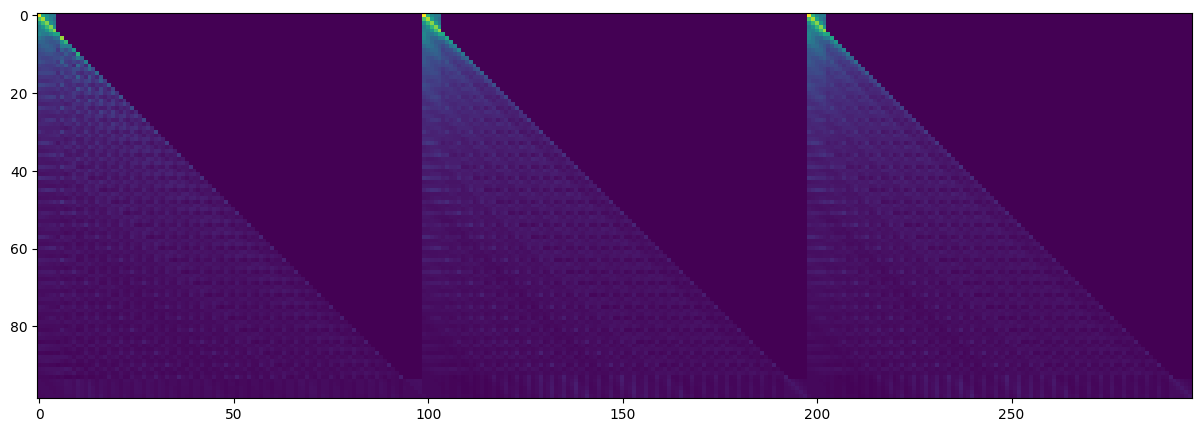

99
2


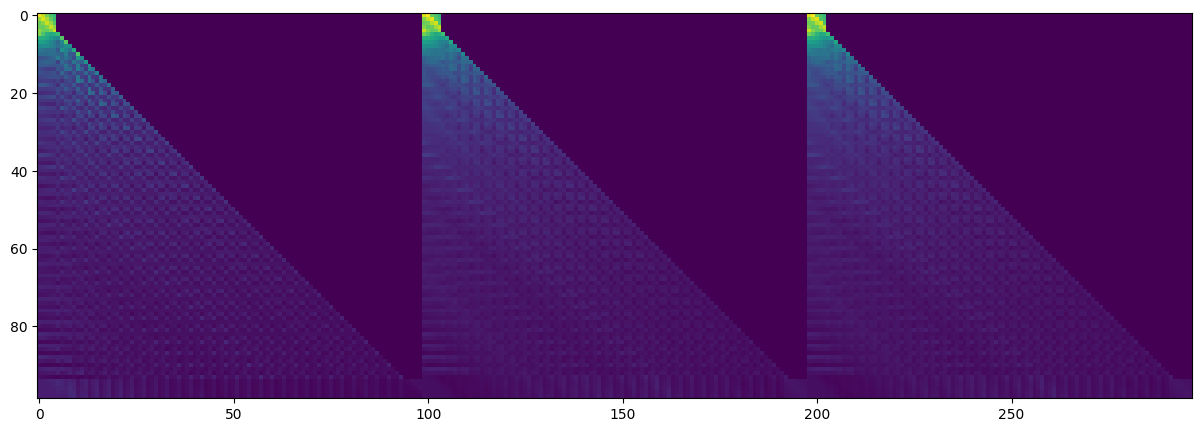

99
2


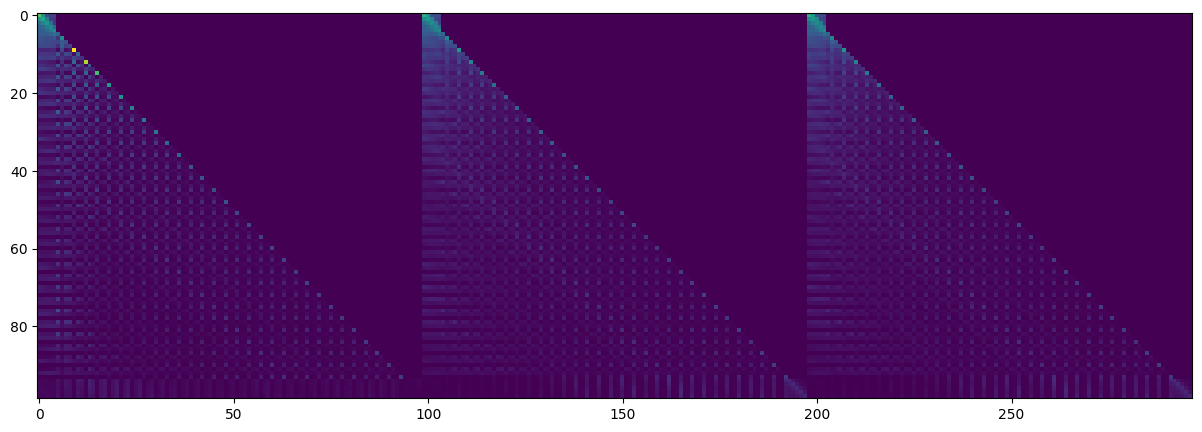

99
2


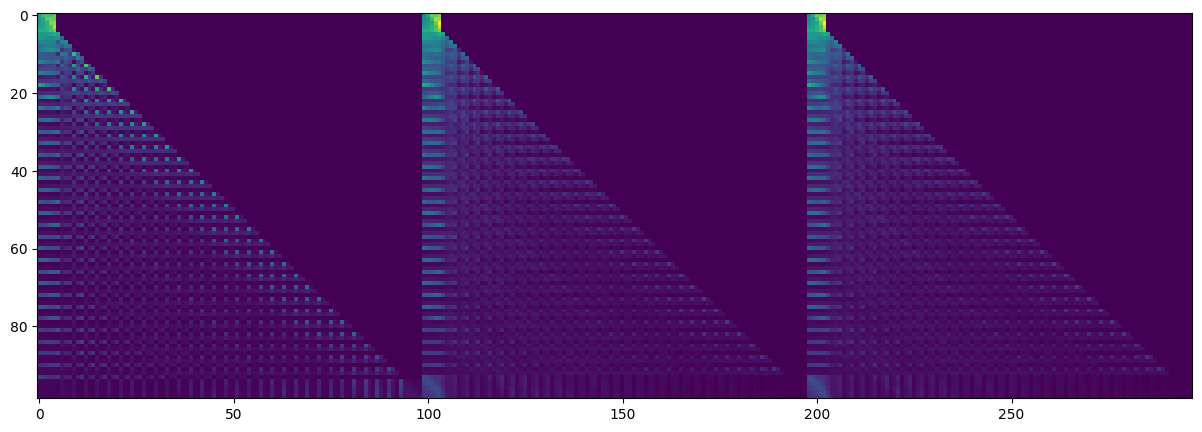

99
2


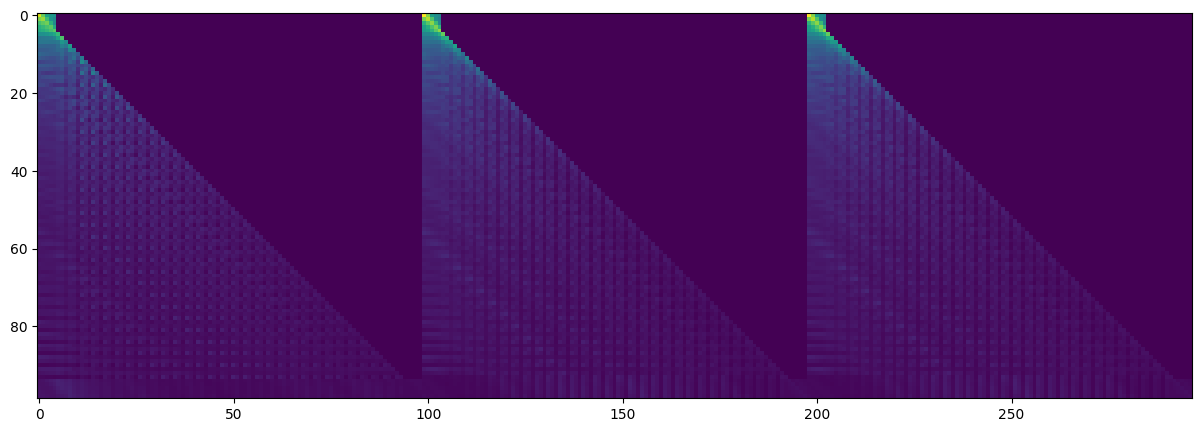

99
2


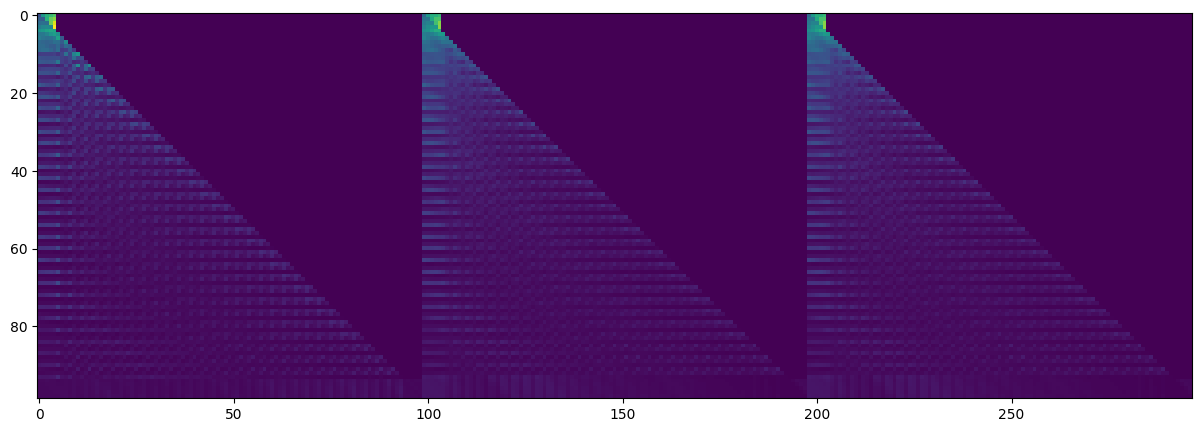

99
2


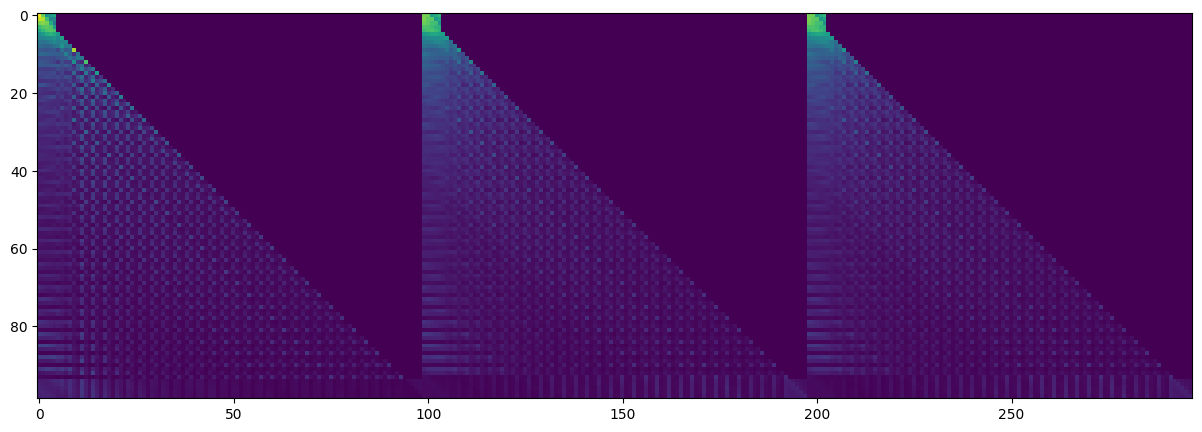

In [16]:
for head in range(n_heads):
    # head = 0

    max_val = max(attn_map[:, :, 0, head].shape[1] for attn_map in attn_maps)
    print(max_val)

    if config["model_mode"] == "RATE":
        attn_seg = [torch.softmax(attn_map[:, :, 0, head], dim=1).numpy() for attn_map in attn_maps if attn_map[:, :, 0, head].shape == (max_val, max_val)]
    else:
        attn_seg = attn_maps_seg

    print(len(attn_seg))

    first_3_seg_attn = np.concatenate((attn_seg[0], attn_seg[len(attn_seg)//2], attn_seg[-1]), axis=1)

    plt.figure(figsize=(15, 5))
    plt.imshow(first_3_seg_attn)

    plt.show()